# Задание **Ultra Lite**


Перепишите ноутбук своими руками. Часть ноутбука можно копировать, но для запоминания важно переписать самому.

1. Функции работы с текстом.
2. Чтение данных.
3. Преобразование текста в индексы: формирование xTrain.
4. Формирование yTrain.
5. Разделение выборки на окна.
6. Одну из функций для создания моделей.
7. Фукция подсчета ошибки.
8. Создание xTrain и yTrain при помощи метода Word2wec GENSIM.

Обучите сеть и проверьте, что она достигает приблизительно похожих результатов, как и на занятии.

# Импорт бибилтотек

In [ ]:
!pip install -q pymorphy2

In [ ]:

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPooling1D, Conv1D, BatchNormalization, Dropout, Conv2DTranspose, Conv1DTranspose, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.utils import plot_model

from gensim.models import word2vec # Импортируем gensim

import os
import re
import numpy as np
from time import time
import nltk 
from nltk.stem import WordNetLemmatizer  
import pymorphy2 

nltk.download('wordnet') # Скачиваем сетку слов для лемматизации

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Функции для работы с текстами

In [ ]:
# Лист тегов и их значений:

# <s1> - Условия 
# <s2> - Запреты
# <s3> - Цена
# <s4> - Условия (относительно дат)
# <s5> - Штрафы
# <s6> - Адреса и местоположения

In [ ]:
# Функция для удаления пунктуационных знаков препинания и еще дополнительных ненужных нам знаков из файла
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read()
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";",'•','%']

  for dS in delSymbols:
    text = text.replace(dS, " ")

  text = re.sub('[.]', ' ', text)
  text = re.sub(':', ' ', text)
  text = re.sub('<', ' <', text)
  text = re.sub('>', '> ', text)

  return ' '.join(text.split()).lower()

In [ ]:
# Функция которая конвертирует исходный текст в лист слов с начальной формой
def text2Words(text):
  morph = pymorphy2.MorphAnalyzer()
  words = text.split(" ")
  return [morph.parse(word)[0].normal_form for word in words]  

# Чтение файла

In [ ]:
directory = '/content/drive/MyDrive/УИИ/Cегментация текста/База договоров/'
os.listdir(directory)[400:410]

['Трудовой договор с медицинским работником.txt',
 'Трудовой договор с коммерческим директором ООО.txt',
 'Трудовой договор с исполнительным директором ООО.txt',
 'Трудовой договор с испытательным сроком.txt',
 'Трудовой договор с кассиром.txt',
 'Трудовой договор с педагогическим работником.txt',
 'Трудовой договор с иностранным работником (подсобный рабочий).txt',
 'Трудовой договор с продавцом.txt',
 'Трудовой договор с работником ООО на срок до 2-х месяцев (полный).txt',
 'Трудовой договор с работником ООО на срок до 2-х месяцев (краткий).txt']

In [ ]:
# Всего договоров
print(len(os.listdir(directory)), 'договора для обучения')

432 договора для обучения


In [ ]:
curTime = time()
agreements = [] # список договоров
for filename in os.listdir(directory):
  txt = readText(directory + filename)
  if txt != "":
    agreements.append(txt)
print(f'Загрузка файла заняла: {round(time() - curTime, 2)} с.')

Загрузка файла заняла: 6.55 с.


In [ ]:
# Пример договора
n = 100
print(os.listdir(directory)[n])
print()
print(agreements[n])

7.ДОГОВОР АРЕНДЫ ЗЕМЕЛЬНОГО УЧАСТКА, НАХОДЯЩЕГОСЯ В ЧАСТНОЙ СОБСТВЕННОСТИ.txt

договор аренды недвижимого имущества г г в лице действующего на основании именуемый в дальнейшем арендодатель с одной стороны и в лице действующего на основании именуемый в дальнейшем арендатор с другой стороны именуемые в дальнейшем стороны заключили настоящий договор в дальнейшем договор о нижеследующем 1 предмет договора 1 1 <s1> арендодатель предоставляет а арендатор принимает во временное владение и пользование недвижимое имущество <s6> расположенное по адресу </s6> общей площадью кв м далее имущество </s1> 1 2 имущество находится в собственности 1 3 <s6> имущество находится в г </s6> 1 4 <s1> на момент заключения договора права третьих лиц на имущество отсутствуют </s1> 1 5 <s1> настоящий договор подлежит регистрации в органах осуществляющих государственную регистрацию прав на недвижимое имущество и сделок с ним в порядке установленном действующим законодательством рф </s1> 2 права и обязанности сторо

In [ ]:
# Конвертирует исходный текст
docs_full = []
currTime = time()
for i in range(len(agreements)):
   docs_full.append(text2Words(agreements[i]))

print(f'Времени потребовалось: {round(time() - curTime, 2)} с.')

Времени потребовалось: 199.49 с.


In [ ]:
# Выводим число записей в наборе данных 
print(len(docs_full))

422


## Разделение на выборки

In [ ]:
# Выбираем итоговое количество данных для обучающей/проверочной и тестовой выборках
docsToTrain = docs_full[0:-10]
docsToTest = docs_full[-10:]

In [ ]:
print('Число текстов в для тестовой проверки в конце ноутбука:', len(docsToTest)) 
print('Число договоров для обучающей и проверочной выборках:',len(docsToTrain)) 
print('Число слов в первом договоре:', len(docsToTrain[0]))

Число текстов в для тестовой проверки в конце ноутбука: 10
Число договоров для обучающей и проверочной выборках: 412
Число слов в первом договоре: 1149


In [ ]:
print('Пример текста обычного:')
print(agreements[100][:63], '\n')
print()
print('Тот же текст, но представленный ввиде лемм:')
print(docsToTrain[100][:10])

Пример текста обычного:
договор аренды недвижимого имущества г г в лице действующего на 


Тот же текст, но представленный ввиде лемм:
['договор', 'аренда', 'недвижимый', 'имущество', 'г', 'г', 'в', 'лицо', 'действовать', 'на']


# Превращение текстов в последовтельность индексов: создание xTrain

In [ ]:
tokenizer = Tokenizer(lower=True, filters='', char_level=False)
tokenizer.fit_on_texts(docs_full)
clean_voc = {} # Создаем пустой словарь

for i in tokenizer.word_index.items():
  clean_voc[i[0]] = i[1]

In [ ]:
print('Словарь всех слов по их частотноти:') 
print(clean_voc, '\n')
print('Длина словаря:', len(clean_voc))

tag = '<s2>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

Словарь всех слов по их частотноти:
{'в': 1, 'договор': 2, 'и': 3, '2': 4, '1': 5, 'по': 6, 'сторона': 7, 'с': 8, 'настоящий': 9, 'на': 10, '3': 11, '<s1>': 12, '</s1>': 13, 'не': 14, '4': 15, 'или': 16, 'за': 17, 'он': 18, 'случай': 19, 'о': 20, '5': 21, '<s3>': 22, '</s3>': 23, 'право': 24, 'работа': 25, 'срок': 26, '<s4>': 27, '</s4>': 28, 'от': 29, 'при': 30, 'они': 31, '6': 32, 'другой': 33, 'быть': 34, 'лицо': 35, 'имущество': 36, 'день': 37, 'действовать': 38, 'арендатор': 39, 'условие': 40, 'для': 41, '7': 42, 'к': 43, 'если': 44, 'п': 45, 'дальнейший': 46, 'работник': 47, 'который': 48, 'а': 49, 'обязательство': 50, 'страховой': 51, 'законодательство': 52, 'порядок': 53, 'сумма': 54, 'размер': 55, 'действие': 56, 'арендодатель': 57, 'свой': 58, 'счёт': 59, 'соответствие': 60, 'указанный': 61, 'именовать': 62, 'мочь': 63, 'из': 64, 'основание': 65, 'обязанность': 66, 'обязать': 67, 'исполнение': 68, 'один': 69, 'страховщик': 70, 'страхователь': 71, 'иной': 72, 'год': 73, 'до': 

In [ ]:
# Превращает текст в последовательность индексов согласно словарю частотности
tok_agreem = tokenizer.texts_to_sequences(docsToTrain)

print("Исходный текст:              ", docsToTrain[50][:20])
print("Последовательность индексов: ", tok_agreem[50][:20])

Исходный текст:               ['договор', 'аренда', 'земельный', 'участок', 'находиться', 'в', 'государственный', 'или', 'муниципальный', 'собственность', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший']
Последовательность индексов:  [2, 116, 211, 169, 253, 1, 204, 16, 1287, 130, 76, 76, 1, 35, 38, 10, 65, 62, 1, 46]


# Создание yTrain

In [ ]:
#  Собираем лист индексов и их мультилейбл класссификации
def getXYSamples(tok_agreem, tags_index):
  tags01 = []
  indices = []

  for agreement in tok_agreem:
    tag_place = [0, 0, 0, 0, 0, 0]
    for ex in agreement:
      if ex in tags_index:
        place = np.argwhere(tags_index==ex)
        if len(place) !=0:
          if place[0][0] < 6:
            tag_place[place[0][0]] = 1
          else:
            tag_place[place[0][0] - 6] = 0
      else:
        tags01.append(tag_place.copy())
        indices.append(ex)
  return indices, tags01

In [ ]:
# Функция получение списка слов из списка индексов
def reverseIndex(clean_voc, x):
  reverse_word_map = dict(map(reversed, clean_voc.items()))
  docs = [reverse_word_map.get(letter) for letter in x]
  return docs

In [ ]:
#<s1> - Условия договора
#<s2> - Запреты
#<s3> - Стоимость
#<s4> - Условия (относительно дат)
#<s5> - Штрафы
#<s6> - Адреса и местоположения

tags_index = ['<s' + str(i) + '>' for i in range(1, 7)] # Лист открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 7)] # Лист закрывающих тегов
tags_index.extend(closetags) # конкатенируем все теги

tags_index = np.array([clean_voc[i] for i in tags_index]) # Получаем инексы всех тегов из словря частотности
print('Индексы всех тегов:', tags_index)

Индексы всех тегов: [ 12 341  22  27 117 278  13 352  23  28 118 272]


In [ ]:
# Получаем теги и создаём листы с ними
curTime = time()
xData, yData = getXYSamples(tok_agreem,tags_index)
decoded_text = reverseIndex(clean_voc, xData) # Превращаем список индексов обратно в список слов
print(f'Время: {round(time() - curTime, 2)} с.')

Время: 3.32 с.


In [ ]:
print('длина xData:', len(xData))
print('длина yData:', len(yData))
print()
print('Посмотрим на исходные слова: ', docsToTrain[0][50:70])
print('Сдекодированые слова:', decoded_text[50:70])
print()
print('Часть xData:     ', xData[50:70])
print('Часть yData:     ', yData[50:70])

длина xData: 410727
длина yData: 410727

Посмотрим на исходные слова:  ['1', 'предмет', 'договор', '1', '1', '<s1>', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь']
Сдекодированые слова: ['1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в']

Часть xData:      [5, 112, 2, 5, 5, 6, 9, 2, 224, 115, 918, 319, 125, 18, 250, 3, 546, 244, 319, 1]
Часть yData:      [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]]


# Разделение выборки на окна

In [ ]:
# Создание выборки из индексов
def getSetFromIndices(wordIndices, xLen, step):
  xBatch = []
  wordsLen = len(wordIndices)
  index = 0
  while (index + xLen <= wordsLen):
    xBatch.append(wordIndices[index:index+xLen])
    index += step
  return xBatch

In [ ]:
xLen = 256
step = 30
embeddingSize = 300 # Пространство Embedding

In [ ]:
#  Генерируем выборки с параметрами наших окон
xTrain = getSetFromIndices(decoded_text, xLen, step)
yTrain = getSetFromIndices(yData, xLen, step)

### Проверка 

In [ ]:
print('Длина xTrain:', len(xTrain))
print('Длина yTrain:', len(yTrain))
print('Длина примера из xTrain:',len(xTrain[0]))
print('Длина примера из yTrain:',len(yTrain[0]), '\n')
print('Пример xTrain', xTrain[0])
print('Пример yTrain', yTrain[0], '\n')

print('Первый пример xTrain:', xTrain[0][step-5:step+5])
print('Второй пример xTrain:', xTrain[1][:10])

Длина xTrain: 13683
Длина yTrain: 13683
Длина примера из xTrain: 256
Длина примера из yTrain: 256 

Пример xTrain ['договор', 'безвозмездный', 'хранение', 'до', 'востребование', 'г', 'г', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'хранитель', 'с', 'один', 'сторона', 'и', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'поклажедатель', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий', 'договор', 'следующий', 'вещь', 'далее', 'вещь', '1', '3', 'при', 'передача', 'вещь', 'по

### Текст в последовательность индексов

In [ ]:
tok_agreemTest = tokenizer.texts_to_sequences(docsToTest)

print("Посмотрим на фрагмент тестового текста:")
print()
print("Исходный текст:                                   ", docsToTest[5][:20])
print("Тот же текст, но как последовательность индексов: ", tok_agreemTest[5][:20])

Посмотрим на фрагмент тестового текста:

Исходный текст:                                    ['трудовой', 'контракт', 'с', 'специалист', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'работодатель', 'с', 'один', 'сторона', 'и', 'гражданин']
Тот же текст, но как последовательность индексов:  [79, 187, 8, 897, 76, 76, 1, 35, 38, 10, 65, 62, 1, 46, 129, 8, 69, 7, 3, 265]


In [ ]:
# Распознаём теги и создаём лист, что их хранят
xDataTest, yDataTest = getXYSamples(tok_agreemTest, tags_index)

# Превращаем из списка индекса обратно в список слов
decoded_text = reverseIndex(clean_voc, xDataTest)

print('Длина xDataTest:', len(xDataTest))
print('Длина yDataTest:', len(yDataTest))
print()
print('Сдекодированные текст:', decoded_text[200:230])
print('Часть xDataTest:     ', xDataTest[200:230])
print('Часть yDataTest:     ', yDataTest[200:230])

Длина xDataTest: 10723
Длина yDataTest: 10723

Сдекодированные текст: ['2', 'основной', 'условие', 'договор', '2', '1', 'гр', 'назначаться', 'на', 'должность', 'директор', 'на', 'основание', 'решение', 'совет', 'директор', 'протокол', 'от', 'год', 'работодатель', 'поручать', 'директор', 'решение', 'весь', 'вопрос', 'текущий', 'деятельность', 'общество', 'за', 'исключение']
Часть xDataTest:      [4, 592, 40, 2, 4, 5, 523, 1530, 10, 495, 217, 10, 65, 280, 537, 217, 872, 29, 73, 129, 1005, 217, 280, 120, 248, 403, 148, 146, 17, 415]
Часть yDataTest:      [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [

In [ ]:
# Генерируем выборки
xTest = getSetFromIndices(decoded_text, xLen, step)
yTest = getSetFromIndices(yDataTest, xLen, step)

print('Длина xTest:', len(xTest))
print('Длина yTest:', len(yTest))
print()

print('Длина примера xTest:',len(xTest[10]))
print('Длина примера yTrain:',len(yTest[10]), '\n')

print('Пример xTest', xTest[10])
print('Пример yTest', yTest[10], '\n')

print('Первый пример xTest:', xTest[0][step-10:step+10])
print('Второй пример xTest:', xTest[1][:15])

Длина xTest: 349
Длина yTest: 349

Длина примера xTest: 256
Длина примера yTrain: 256 

Пример xTest ['договор', 'заключаться', 'на', 'неопределённый', 'срок', '3', '2', 'на', 'основание', 'решение', 'совет', 'директор', 'директор', 'издавать', 'приказ', 'о', 'свой', 'вступление', 'в', 'должность', '4', 'компетенция', 'директор', '4', '1', 'директор', 'решать', 'всё', 'вопрос', 'текущий', 'деятельность', 'банк', 'за', 'исключение', 'вопрос', 'отнести', 'к', 'исключительный', 'компетенция', 'общий', 'собрание', 'акционер', 'к', 'компетенция', 'совет', 'директор', 'или', 'правление', '4', '2', 'директор', 'без', 'доверенность', 'действовать', 'от', 'имя', 'банк', 'представлять', 'он', 'интерес', 'совершать', 'сделка', 'от', 'имя', 'банк', 'утверждать', 'штат', 'издавать', 'приказ', 'и', 'давать', 'указание', 'обязательный', 'для', 'исполнение', 'весь', 'работник', 'банк', '4', '3', 'право', 'и', 'обязанность', 'директор', 'по', 'осуществление', 'руководство', 'текущий', 'деятельность', '

# Функции создания моделей

## Функция, подсчета **ошибки**

In [ ]:
def dice_coef(y_true, y_pred):
  return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

## Модель **Conv1D**

In [ ]:
def create_Conv1D(xLen, embeddingsSize):
  text_input_layear = Input((xLen, embeddingsSize))
  text_layer = Conv1D(16, 3, padding='same', activation='relu')(text_input_layear)
  text_layer = Conv1D(16, 3, padding='same', activation='relu')(text_layer)
  text_layer = Conv1D(16, 3, padding='same', activation='relu')(text_layer)
  text_layer = Conv1D(GENSIMtrainY.shape[-1], 3, padding='same', activation='sigmoid')(text_layer)

  model = Model(text_input_layear, text_layer)
  model.compile(optimizer=Adadelta(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])

  return model

## Модель **PSPnet**

In [ ]:
def create_PSPNet(conv_size = 64, num_classes = 6, input_shape = (30, 300)):
    img_input = Input(input_shape)

    # Блок 1
    x = Conv1D(conv_size, 3, padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(conv_size, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_mp_2 = MaxPooling1D(2)(x)
    x_mp_4 = MaxPooling1D(4)(x)
    x_mp_8 = MaxPooling1D(8)(x)
    x_mp_16 = MaxPooling1D(16)(x)
    x_mp_32 = MaxPooling1D(32)(x)

    x_mp_2 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_2)
    x_mp_2 = Dropout(0.5)(x_mp_2)

    x_mp_4 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_4)
    x_mp_4 = Dropout(0.5)(x_mp_4)

    x_mp_8 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_8)
    x_mp_8 = Dropout(0.5)(x_mp_8)

    x_mp_16 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_16)
    x_mp_16 = Dropout(0.5)(x_mp_16)

    x_mp_32 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_32)
    x_mp_32 = Dropout(0.5)(x_mp_32) 

    x_mp_2 = Conv1DTranspose(conv_size, 2, strides=2)(x_mp_2)
    x_mp_2 = Activation('relu')(x_mp_2)

    x_mp_4 = Conv1DTranspose(conv_size, 4, strides=4)(x_mp_4)
    x_mp_4 = Activation('relu')(x_mp_4)

    x_mp_8 = Conv1DTranspose(conv_size, 8, strides=8)(x_mp_8)
    x_mp_8 = Activation('relu')(x_mp_8)

    x_mp_16 = Conv1DTranspose(conv_size, 16, strides=16)(x_mp_16)
    x_mp_16 = Activation('relu')(x_mp_16)

    x_mp_32 = Conv1DTranspose(conv_size, 32, strides=32)(x_mp_32)
    x_mp_32 = Activation('relu')(x_mp_32)

    fin = concatenate([img_input, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])    
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(fin)

    model = Model(img_input, fin)
    model.compile(optimizer=Adadelta(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model

## Модель **Unet**

In [ ]:
def create_unet(k = 1, num_classes = 6, input_shape= (30, 300)):
    img_input = Input(input_shape) 

    # Блок 1
    x = Conv1D(64 * k , 3, padding='same')(img_input) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(64 * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation('relu')(x) 

    # Блок 2
    x = MaxPooling1D()(block_1_out)
    x = Conv1D(128 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    # Блок 3
    x = MaxPooling1D()(block_2_out)
    x = Conv1D(256 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # Блок 4
    x = MaxPooling1D()(block_3_out)
    x = Conv1D(512 * k, 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    x = block_4_out 

    # UP 2
    x = Conv1DTranspose(256 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_3_out]) 
    x = Conv1D(256 * k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv1DTranspose(128 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_2_out])
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv1DTranspose(64 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(0.0025), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
  
    return model

# Создание xTrain и yTrain используя Word2Vec

In [ ]:
# Функция для дополнением нулями
def pad_zeros(phrase, xLen=256):
  while len(phrase) < xLen:
    phrase.append[0] * embeddingSize
  if len(phrase) > xLen:
    phrase = phrase[:xLen]
  return phrase

In [ ]:
# Создаём выборку
def getSets(model, senI, tagI):
  xVector = []
  tmp = []
  for text in senI:
    tmp=[]
    for word in text:
      try:
        tmp.append(model.wv[word])
      except:
        pass

    xVector.append(pad_zeros(tmp, xLen))
  temp = np.array(xVector)
  return np.array(xVector, dtype = np.float32), np.array(tagI)

In [ ]:
# Подаём лист листов слов в word2vec для обучающей выборке

# size = embeddingSize  - Размер ембеддинга
# window = 10           - Минимальное расстояния между эмбеддинг словами
# min_count = 1         - Игнорируем все слова с частотой меньше чем 1
# workers = 10          - Число потоков на обучение эмбеддинга
# iter = 20             - Число эпох на обучение эмбеддинга
# max_vocab_size = 1e5  - Число слов в "словарном запасе" word2vec

In [ ]:
curTime = time()

modelGENSIM = word2vec.Word2Vec(xTrain + xTest, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10, max_vocab_size = 1e5)
print(f'Обучение GENSIM заняло: {round(time() - curTime, 2)} с.')

Обучение GENSIM заняло: 66.81 с.


In [ ]:
# Пример превращения слова в вектор при помощи GENSIM
modelGENSIM.wv['срок']

array([-1.5965191e+00, -9.5726269e-01,  1.6975039e+00, -9.1865754e-01,
       -1.9105551e+00, -9.4983870e-01, -1.0758909e+00,  2.5749459e+00,
       -3.3204494e+00, -4.7672534e-01,  3.2461770e+00,  1.7973239e+00,
        2.9183528e+00,  1.0442010e+00, -2.7633758e+00,  1.2287105e+00,
       -2.2059691e+00, -1.2727596e+00,  3.7409854e+00, -1.6889954e+00,
       -2.5104244e+00, -4.1902363e-02,  3.4682183e+00,  2.1995471e+00,
        4.3168273e-02,  1.9672830e+00, -3.9013116e+00,  9.1304868e-01,
       -4.1307783e-01, -3.6080034e+00,  9.3332487e-01,  1.5243112e+00,
        9.0249836e-01, -4.2129797e-01, -4.8273091e+00,  6.2176245e-01,
       -4.4341359e+00,  6.8090206e-01,  1.3243926e+00,  2.2448850e-01,
        5.7591373e-01, -7.2337472e-01, -1.4634329e+00,  7.8419489e-01,
        8.4327334e-01,  1.1019365e+00, -3.4399351e-01,  1.4032966e+00,
        1.3600605e+00, -2.4395790e+00, -9.3204254e-01, -7.7213746e-01,
       -3.2847661e-01,  4.5174778e-01,  5.1845141e-02, -2.0569518e+00,
      

In [ ]:
GENSIMtrainX, GENSIMtrainY = getSets(modelGENSIM, xTrain, yTrain)
GENSIMtestX, GENSIMtestY = getSets(modelGENSIM, xTest, yTest)

In [ ]:
print('Размерности xTrain:', GENSIMtrainX.shape)
print('Размерности yTrain:', GENSIMtrainY.shape)

Размерности xTrain: (13683, 256, 300)
Размерности yTrain: (13683, 256, 6)


# Создание и обучение нейронных сетей

## Линейная **Conv1D** сеть

In [ ]:
model_Conv1D = create_Conv1D(xLen, embeddingSize)

### Просмотр модели

summary

In [ ]:
model_Conv1D.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 300)]        0         
                                                                 
 conv1d (Conv1D)             (None, 256, 16)           14416     
                                                                 
 conv1d_1 (Conv1D)           (None, 256, 16)           784       
                                                                 
 conv1d_2 (Conv1D)           (None, 256, 16)           784       
                                                                 
 conv1d_3 (Conv1D)           (None, 256, 6)            294       
                                                                 
Total params: 16,278
Trainable params: 16,278
Non-trainable params: 0
_________________________________________________________________


plot_model

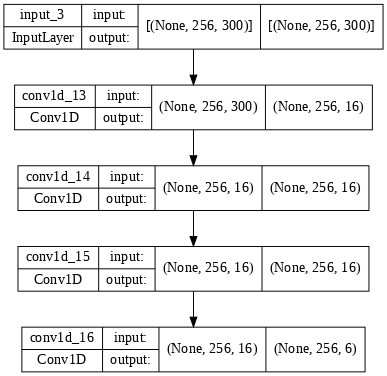

In [ ]:
plot_model(model_Conv1D, dpi = 70, show_shapes=True)

### Обучение сети

In [ ]:
history_conv1D = model_Conv1D.fit(GENSIMtrainX, GENSIMtrainY, epochs=50, batch_size=200, validation_data=(GENSIMtestX, GENSIMtestY))
model_Conv1D.save_weights('/content/drive/MyDrive/УИИ/Cегментация текста/conv1D.h5')


Epoch 1/50
69/69 [==============================] - 16s 62ms/step - loss: 1.6952 - dice_coef: 0.1852 - val_loss: 1.4300 - val_dice_coef: 0.1846
Epoch 2/50
69/69 [==============================] - 3s 41ms/step - loss: 1.6941 - dice_coef: 0.1853 - val_loss: 1.4291 - val_dice_coef: 0.1846
Epoch 3/50
69/69 [==============================] - 3s 41ms/step - loss: 1.6929 - dice_coef: 0.1852 - val_loss: 1.4282 - val_dice_coef: 0.1846
Epoch 4/50
69/69 [==============================] - 3s 41ms/step - loss: 1.6917 - dice_coef: 0.1854 - val_loss: 1.4273 - val_dice_coef: 0.1846
Epoch 5/50
69/69 [==============================] - 3s 42ms/step - loss: 1.6904 - dice_coef: 0.1853 - val_loss: 1.4264 - val_dice_coef: 0.1846
Epoch 6/50
69/69 [==============================] - 3s 42ms/step - loss: 1.6891 - dice_coef: 0.1855 - val_loss: 1.4254 - val_dice_coef: 0.1846
Epoch 7/50
69/69 [==============================] - 3s 41ms/step - loss: 1.6877 - dice_coef: 0.1854 - val_loss: 1.4243 - val_dice_coef: 0.184

## сеть **PSPnet**

In [ ]:
model_PSPnet = create_PSPNet(input_shape=(xLen, embeddingSize))

### Просмотр модели

summary

In [ ]:
model_PSPnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 300)]   0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 256, 64)      57664       ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 64)     256         ['conv1d_4[0][0]']               
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 256, 64)      0           ['batch_normalization[0][0]

plot_model

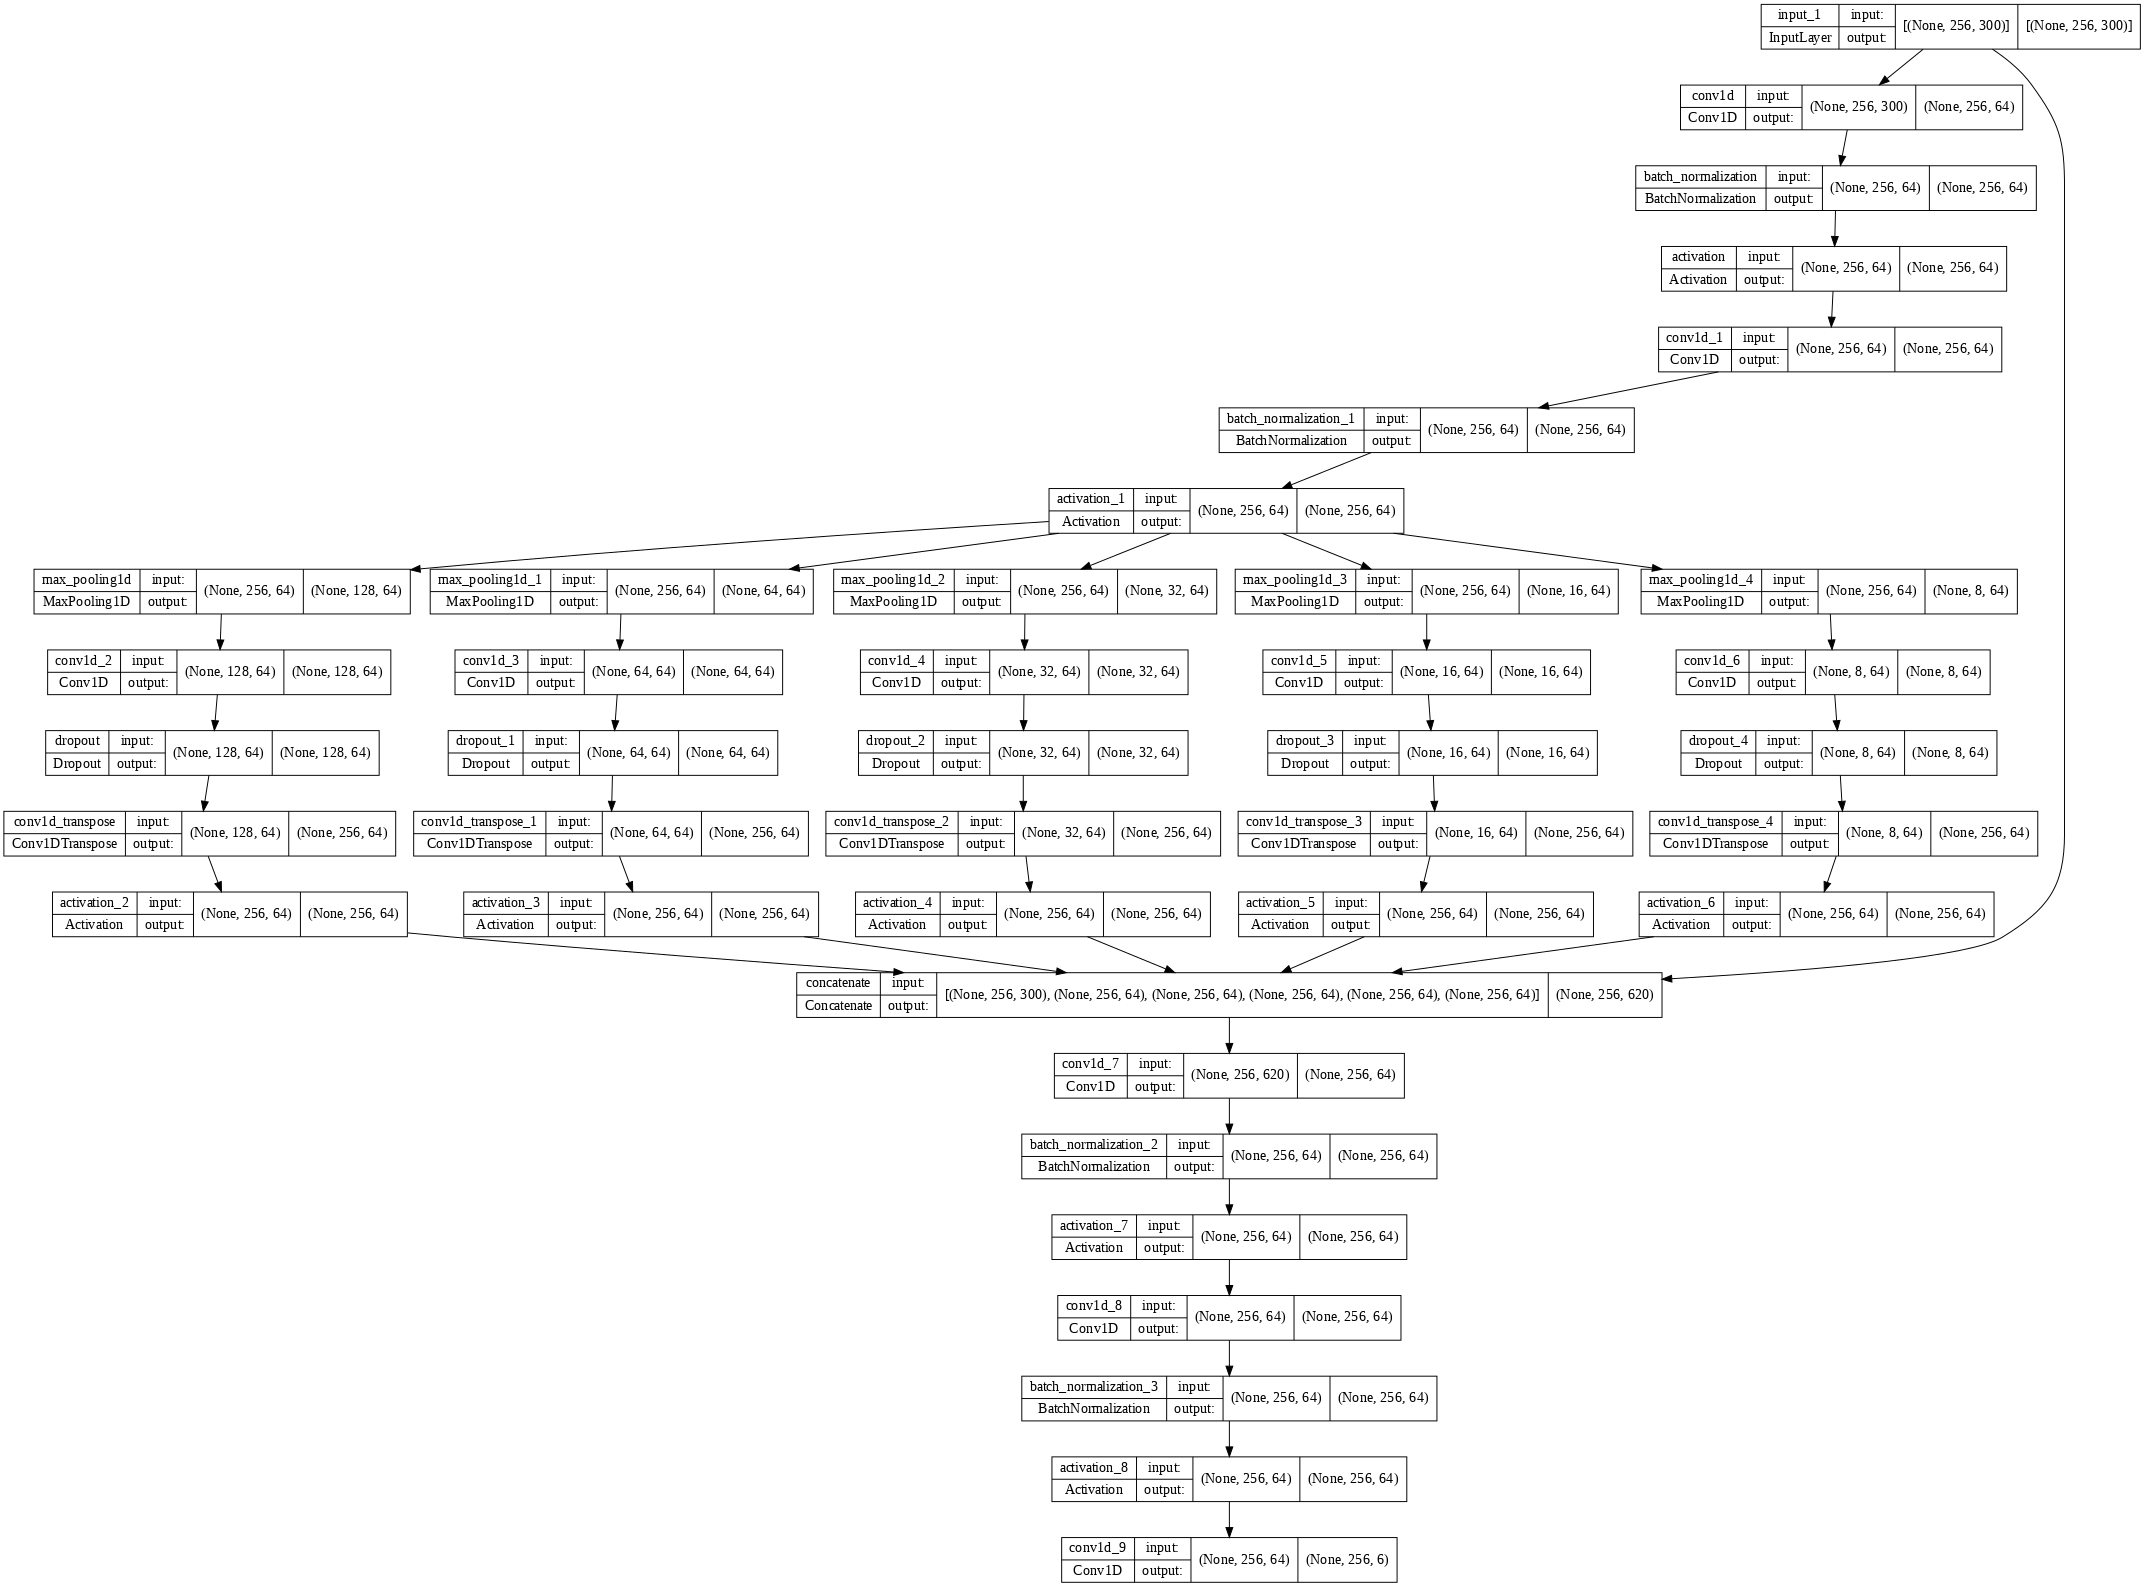

In [ ]:
plot_model(model_PSPnet, dpi = 70, show_shapes=True)

### Обучение сети

In [ ]:
history_PSPnet = model_PSPnet.fit(GENSIMtrainX, GENSIMtrainY, epochs=50, batch_size=200, validation_data=(GENSIMtestX, GENSIMtestY))
model_PSPnet.save_weights('/content/drive/MyDrive/УИИ/Cегментация текста/model_PSPnet.h5')

Epoch 1/50
69/69 [==============================] - 26s 135ms/step - loss: 1.3630 - dice_coef: 0.2160 - val_loss: 1.2775 - val_dice_coef: 0.1917
Epoch 2/50
69/69 [==============================] - 6s 93ms/step - loss: 1.3523 - dice_coef: 0.2171 - val_loss: 1.2225 - val_dice_coef: 0.1969
Epoch 3/50
69/69 [==============================] - 6s 93ms/step - loss: 1.3416 - dice_coef: 0.2183 - val_loss: 1.1991 - val_dice_coef: 0.2002
Epoch 4/50
69/69 [==============================] - 6s 94ms/step - loss: 1.3304 - dice_coef: 0.2196 - val_loss: 1.1848 - val_dice_coef: 0.2025
Epoch 5/50
69/69 [==============================] - 6s 93ms/step - loss: 1.3192 - dice_coef: 0.2208 - val_loss: 1.1735 - val_dice_coef: 0.2043
Epoch 6/50
69/69 [==============================] - 7s 96ms/step - loss: 1.3080 - dice_coef: 0.2221 - val_loss: 1.1631 - val_dice_coef: 0.2058
Epoch 7/50
69/69 [==============================] - 7s 94ms/step - loss: 1.2965 - dice_coef: 0.2233 - val_loss: 1.1531 - val_dice_coef: 0.20

### PSPnet **256** нейронов в свёрточном ядре

In [ ]:
model_256_PSPnet = create_PSPNet(conv_size = 256, input_shape=(xLen, embeddingSize))
history_56_PSPnet = model_256_PSPnet.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=30, batch_size=64)
model_256_PSPnet.save_weights('/content/drive/MyDrive/УИИ/Cегментация текста/model_256_PSPnet.h5')

Epoch 1/30
214/214 [==============================] - 47s 140ms/step - loss: 1.5887 - dice_coef: 0.1972 - val_loss: 1.3092 - val_dice_coef: 0.1875
Epoch 2/30
214/214 [==============================] - 28s 132ms/step - loss: 1.4590 - dice_coef: 0.2099 - val_loss: 1.2258 - val_dice_coef: 0.2010
Epoch 3/30
214/214 [==============================] - 29s 137ms/step - loss: 1.3432 - dice_coef: 0.2227 - val_loss: 1.1355 - val_dice_coef: 0.2126
Epoch 4/30
214/214 [==============================] - 29s 137ms/step - loss: 1.2453 - dice_coef: 0.2349 - val_loss: 1.0606 - val_dice_coef: 0.2232
Epoch 5/30
214/214 [==============================] - 29s 134ms/step - loss: 1.1651 - dice_coef: 0.2466 - val_loss: 1.0003 - val_dice_coef: 0.2331
Epoch 6/30
214/214 [==============================] - 29s 136ms/step - loss: 1.1005 - dice_coef: 0.2576 - val_loss: 0.9537 - val_dice_coef: 0.2425
Epoch 7/30
214/214 [==============================] - 29s 137ms/step - loss: 1.0495 - dice_coef: 0.2680 - val_loss: 0.

### PSPnet **512** нейронов в свёрточном ядре

In [ ]:
model_512_PSPnet = create_PSPNet(conv_size = 512, input_shape=(xLen, embeddingSize))
history_512_PSPnet = model_512_PSPnet.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=20, batch_size=64)
model_512_PSPnet.save_weights('/content/drive/MyDrive/УИИ/Cегментация текста/model_512_PSPnet.h5')

Epoch 1/20
214/214 [==============================] - 110s 431ms/step - loss: 1.3561 - dice_coef: 0.2165 - val_loss: 1.1024 - val_dice_coef: 0.2082
Epoch 2/20
214/214 [==============================] - 89s 418ms/step - loss: 1.1934 - dice_coef: 0.2427 - val_loss: 0.9928 - val_dice_coef: 0.2344
Epoch 3/20
214/214 [==============================] - 90s 419ms/step - loss: 1.0741 - dice_coef: 0.2686 - val_loss: 0.9144 - val_dice_coef: 0.2575
Epoch 4/20
214/214 [==============================] - 90s 418ms/step - loss: 0.9925 - dice_coef: 0.2927 - val_loss: 0.8662 - val_dice_coef: 0.2779
Epoch 5/20
214/214 [==============================] - 90s 419ms/step - loss: 0.9404 - dice_coef: 0.3136 - val_loss: 0.8361 - val_dice_coef: 0.2958
Epoch 6/20
214/214 [==============================] - 90s 419ms/step - loss: 0.9093 - dice_coef: 0.3297 - val_loss: 0.8174 - val_dice_coef: 0.3105
Epoch 7/20
214/214 [==============================] - 90s 418ms/step - loss: 0.8886 - dice_coef: 0.3420 - val_loss: 0

## Сеть **UNET**

In [ ]:
model_UNET = create_unet(input_shape=(xLen, embeddingSize))

### Просмотр модели

summary

In [ ]:
model_UNET.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 300)]   0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 256, 64)      57664       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 256, 64)     256         ['conv1d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 256, 64)      0           ['batch_normalization_4[0][

plot_model

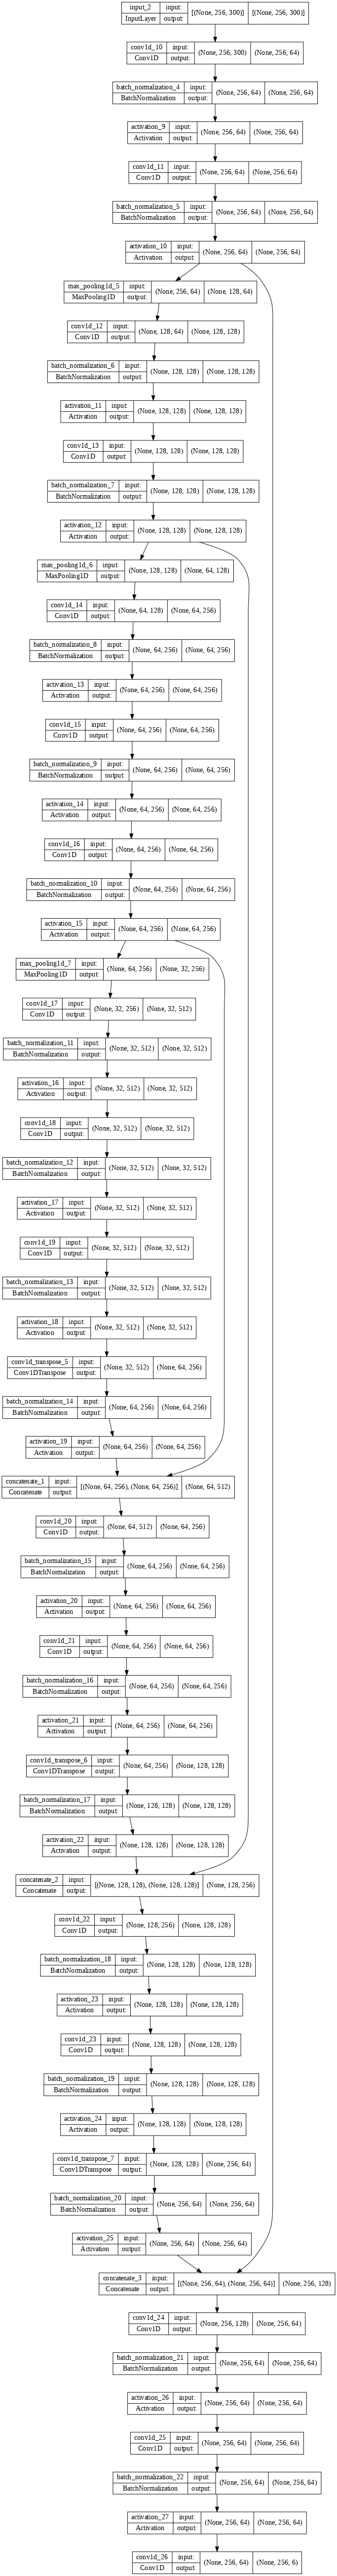

In [ ]:
plot_model(model_UNET, dpi = 70, show_shapes=True)

### Обучение сети

In [ ]:
history = model_UNET.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=30, batch_size=64)
model_UNET.save_weights('/content/drive/MyDrive/УИИ/Cегментация текста/model_UNET.h5')

Epoch 1/30
214/214 [==============================] - 34s 78ms/step - loss: 0.9967 - dice_coef: 0.3821 - val_loss: 2.0971 - val_dice_coef: 0.2938
Epoch 2/30
214/214 [==============================] - 14s 65ms/step - loss: 1.6364 - dice_coef: 0.3334 - val_loss: 3.4133 - val_dice_coef: 0.2430
Epoch 3/30
214/214 [==============================] - 14s 66ms/step - loss: 2.8050 - dice_coef: 0.3288 - val_loss: 1.0620 - val_dice_coef: 0.2486
Epoch 4/30
214/214 [==============================] - 14s 67ms/step - loss: 4.5113 - dice_coef: 0.3309 - val_loss: 1.3410 - val_dice_coef: 0.2352
Epoch 5/30
214/214 [==============================] - 15s 69ms/step - loss: 6.6078 - dice_coef: 0.3330 - val_loss: 2.4607 - val_dice_coef: 0.2598
Epoch 6/30
214/214 [==============================] - 14s 67ms/step - loss: 8.8379 - dice_coef: 0.3352 - val_loss: 2.5143 - val_dice_coef: 0.2602
Epoch 7/30
214/214 [==============================] - 14s 67ms/step - loss: 11.5907 - dice_coef: 0.3369 - val_loss: 1.8933 -

# Проверяем работу сети

In [ ]:
def recognizeSet(XX, YY, model, tags, length, value):
  correct_list = np.array([0] * 6)
  incorrect_list =  np.array([0] * 6)
  XX_array = XX
  YY_array = YY
  pred = model.predict(XX_array)
  pred[pred < value] = 0
  pred[pred > value] = 1

  for element in range(YY_array.shape[0]):
    for word in range(YY_array.shape[1]):
      for category in range(YY_array.shape[2]):
        if pred[element][word][category] == YY_array[element][word][category]:
          correct_list[category] += 1
        else:
          incorrect_list[category] += 1
          
  for i in range(6):
   print("Сеть распознала категорию  '{}' с точностью в {}%".format(tags[i], round(100*correct_list[i]/(correct_list[i] + incorrect_list[i]), 2)))
  total = round(100*np.mean(correct_list/(correct_list + incorrect_list)),2) 
  print("Средняя точность {}%".format(total))

In [ ]:
tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']

# s1 Условия
# s2 Запреты
# s3 Стоимость (услуг и прочее)
# s4 Условия (относительно дат - дедлайны)
# s5 Штрафы
# s6 Адреса и местоположения

In [ ]:
# Загружаем все обученные ранее модели
model_Conv1D = create_Conv1D(xLen, embeddingSize)
model_512_PSPnet = create_PSPNet(conv_size = 512, input_shape=(xLen, embeddingSize))
model_UNET = create_unet(input_shape=(xLen, embeddingSize))

# Загружаем сохраненные веса
model_Conv1D.load_weights('/content/drive/MyDrive/УИИ/Cегментация текста/conv1D.h5')
model_512_PSPnet.load_weights('/content/drive/MyDrive/УИИ/Cегментация текста/model_512_PSPnet.h5')
model_UNET.load_weights('/content/drive/MyDrive/УИИ/Cегментация текста/model_UNET.h5')


In [ ]:
recognizeSet(GENSIMtestX, GENSIMtestY, model_Conv1D, tags, xLen, 0.5)

Сеть распознала категорию  'S1' с точностью в 67.3%
Сеть распознала категорию  'S2' с точностью в 95.85%
Сеть распознала категорию  'S3' с точностью в 32.47%
Сеть распознала категорию  'S4' с точностью в 25.4%
Сеть распознала категорию  'S5' с точностью в 33.45%
Сеть распознала категорию  'S6' с точностью в 94.38%
Средняя точность 58.14%


In [ ]:
recognizeSet(GENSIMtestX, GENSIMtestY, model_512_PSPnet, tags, xLen, 0.5) # Проверяем PSPnet архитектуру

Сеть распознала категорию  'S1' с точностью в 54.95%
Сеть распознала категорию  'S2' с точностью в 97.98%
Сеть распознала категорию  'S3' с точностью в 51.28%
Сеть распознала категорию  'S4' с точностью в 73.38%
Сеть распознала категорию  'S5' с точностью в 86.57%
Сеть распознала категорию  'S6' с точностью в 99.91%
Средняя точность 77.35%


In [ ]:
recognizeSet(GENSIMtestX, GENSIMtestY, model_UNET, tags, xLen, 0.1) # Проверяем UNET архитектуру

Сеть распознала категорию  'S1' с точностью в 45.47%
Сеть распознала категорию  'S2' с точностью в 75.72%
Сеть распознала категорию  'S3' с точностью в 33.41%
Сеть распознала категорию  'S4' с точностью в 35.29%
Сеть распознала категорию  'S5' с точностью в 33.92%
Сеть распознала категорию  'S6' с точностью в 58.36%
Средняя точность 47.03%


# Выводы:

1. Весь ноутбук переписывался в ручную что является хорошей практикой
2. Как видно подготовка данных занимает большую часть времени и от правильной подготовки в большей степени зависит результат.
3. Так же выбор оптимальной архитектуры нейронной сети и подбор гиперпараметров так же влияет на конечный результат.
4. Для лучших результатов было обучение на большем кол-ве эпох чем в уроке. 
5. Лучше всех показала себя архитектура **PSPnet** с **512** нейронов в свёрточном ядре.
